In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import pickle
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

In [3]:
df = pd.read_csv('../data/zillow_data.csv')
df

RegionID  RegionName                 City State              Metro  \
0         84654       60657              Chicago    IL            Chicago   
1         90668       75070             McKinney    TX  Dallas-Fort Worth   
2         91982       77494                 Katy    TX            Houston   
3         84616       60614              Chicago    IL            Chicago   
4         93144       79936              El Paso    TX            El Paso   
...         ...         ...                  ...   ...                ...   
14718     58333        1338             Ashfield    MA    Greenfield Town   
14719     59107        3293            Woodstock    NH          Claremont   
14720     75672       40404                Berea    KY           Richmond   
14721     93733       81225  Mount Crested Butte    CO                NaN   
14722     95851       89155             Mesquite    NV          Las Vegas   

      CountyName  SizeRank   1996-04   1996-05   1996-06  ...  2017-07  \
0           Cook         1  334200.0  335400.0  336500.0  ...  1005500   
1         Collin         2  235700.0  236900.0  236700.0  ...   308000   
2         Harris         3  210400.0  212200.0  212200.0  ...   321000   
3           Cook         4  498100.0  500900.0  503100.0  ...  1289800   
4        El Paso         5   77300.0   77300.0   77300.0  ...   119100   
...          ...       ...       ...       ...       ...  ...      ...   
14718   Franklin     14719   94600.0   94300.0   94000.0  ...   216800   
14719    Grafton     14720   92700.0   92500.0   92400.0  ...   202100   
14720    Madison     14721   57100.0   57300.0   57500.0  ...   121800   
14721   Gunnison     14722  191100.0  192400.0  193700.0  ...   662800   
14722      Clark     14723  176400.0  176300.0  176100.0  ...   333800   

       2017-08  2017-09  2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  \
0      1007500  1007800  1009600  1013300  1018700  1024400  1030700  1033800   
1       310000   312500   314100   315000   316600   318100   319600   321100   
2       320600   320200   320400   320800   321200   321200   323000   326900   
3      1287700  1287400  1291500  1296600  1299000  1302700  1306400  1308500   
4       119400   120000   120300   120300   120300   120300   120500   121000   
...        ...      ...      ...      ...      ...      ...      ...      ...   
14718   217700   218600   218500   218100   216400   213100   209800   209200   
14719   208400   212200   215200   214300   213100   213700   218300   222700   
14720   122800   124600   126700   128800   130600   131700   132500   133000   
14721   671200   682400   695600   695500   694700   706400   705300   681500   
14722   336400   339700   343800   346800   348900   350400   353000   356000   

       2018-04  
0      1030600  
1       321800  
2       329900  
3      1307000  
4       121500  
...        ...  
14718   209300  
14719   225800  
14720   133400  
14721   664400  
14722   357200  

[14723 rows x 272 columns]

In [4]:
df_time_series = pd.DataFrame(index=pd.to_datetime(df.columns[7:]), data=np.ones(len(df.columns)-7))
for i in range(df.shape[0]):
    df_time_series[df['RegionName'][i]] = df.iloc[i,7:]
df_time_series.drop(df_time_series.columns[0],axis=1, inplace=True)
df_time_series

60657   75070   77494    60614   79936   77084   10467   60640  \
1996-04-01   334200  235700  210400   498100   77300   95000  152900  216500   
1996-05-01   335400  236900  212200   500900   77300   95200  152700  216700   
1996-06-01   336500  236700  212200   503100   77300   95400  152600  216900   
1996-07-01   337600  235400  210700   504600   77300   95700  152400  217000   
1996-08-01   338500  233300  208300   505500   77400   95900  152300  217100   
...             ...     ...     ...      ...     ...     ...     ...     ...   
2017-12-01  1018700  316600  321200  1299000  120300  162800  414300  777900   
2018-01-01  1024400  318100  321200  1302700  120300  162800  413900  778500   
2018-02-01  1030700  319600  323000  1306400  120500  162900  411400  780500   
2018-03-01  1033800  321100  326900  1308500  121000  163500  413200  782800   
2018-04-01  1030600  321800  329900  1307000  121500  164300  417900  782800   

             77449    94109  ...   3765    84781   12429   97028   12720  \
1996-04-01   95400   766000  ...   80800  135900   78300  136200   62500   
1996-05-01   95600   771100  ...   80100  136300   78300  136600   62600   
1996-06-01   95800   776500  ...   79400  136600   78200  136800   62700   
1996-07-01   96100   781900  ...   78600  136900   78200  136800   62700   
1996-08-01   96400   787300  ...   77900  137100   78100  136700   62700   
...            ...      ...  ...     ...     ...     ...     ...     ...   
2017-12-01  172300  3778700  ...  123400  257600  171300  341000  122800   
2018-01-01  173300  3770800  ...  124400  258000  172400  342300  123200   
2018-02-01  174200  3763100  ...  125500  260600  173600  345000  123200   
2018-03-01  175400  3779800  ...  126600  264700  175800  348000  120700   
2018-04-01  176200  3813500  ...  127500  266800  177500  349300  117700   

             1338    3293    40404   81225   89155  
1996-04-01   94600   92700   57100  191100  176400  
1996-05-01   94300   92500   57300  192400  176300  
1996-06-01   94000   92400   57500  193700  176100  
1996-07-01   93700   92200   57700  195000  176000  
1996-08-01   93400   92100   58000  196300  175900  
...            ...     ...     ...     ...     ...  
2017-12-01  216400  213100  130600  694700  348900  
2018-01-01  213100  213700  131700  706400  350400  
2018-02-01  209800  218300  132500  705300  353000  
2018-03-01  209200  222700  133000  681500  356000  
2018-04-01  209300  225800  133400  664400  357200  

[265 rows x 14723 columns]

In [5]:
df_time_series.isna().sum().sum()

156891

In [6]:
df_nv = df[df['State'] == 'NV']
nv_zipcodes = df_nv.RegionName.tolist()
nv_zipcodes[0]

89108

In [7]:
df_time_series = df_time_series[nv_zipcodes]

In [8]:
df_time_series.fillna(method='bfill', inplace=True)

/Users/ferityikar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [9]:
df_time_series.isna().sum().sum()

0

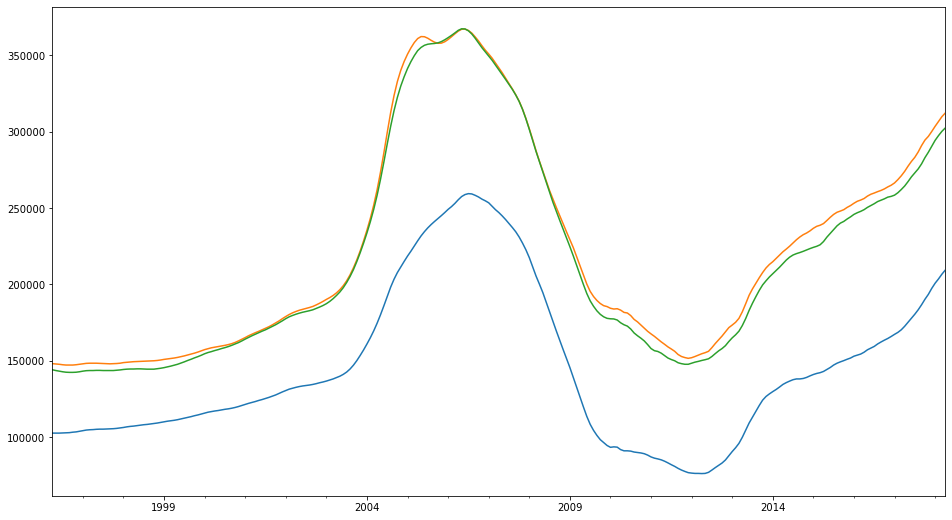

In [10]:
df_time_series.iloc[:,0].plot(figsize=(16,9))
df_time_series.iloc[:,7].plot()
df_time_series.iloc[:,4].plot();

# RNN Model

In [11]:
size = int(len(df_time_series)*.85)
train_pre = df_time_series.iloc[:size]
test = df_time_series.iloc[size:]
size2 = int(len(train_pre)*.85)
train = train_pre.iloc[:size2]
validation = train_pre.iloc[size2:]


We are trying a RNN model to see how it does on our first zipcode

In [12]:
x = 3
train_data = train.iloc[:,x:x+1].values.astype(int)
val_data = validation.iloc[:,x:x+1].values.astype(int)
test_data = test.iloc[:,x:x+1].values.astype(int)

In [13]:
scaler = MinMaxScaler(feature_range=(0,1))
train_data_scaled = scaler.fit_transform(train_data)

Creating a dataset with 60 timesteps (5 years)

In [14]:
X_train = []
y_train = []
for i in range(60,len(train_data_scaled)):
    X_train.append(train_data_scaled[i-60:i])
    y_train.append(train_data_scaled[i])
X_train = np.array(X_train)
y_train = np.array(y_train)

# Validation Data 
data_total_val = pd.concat((train.iloc[:,x:x+1], validation.iloc[:,x:x+1]),axis=0)
val_input = data_total_val[len(train)-60:].values
val_input = scaler.transform(val_input)

X_val = []
y_val = []
for i in range(60,len(val_input)):
    X_val.append(val_input[i-60:i])
    y_val.append(val_input[i])
X_val = np.array(X_val)
y_val = np.array(y_val)


# Test Data 
data_total = pd.concat((train_pre.iloc[:,x:x+1], test.iloc[:,x:x+1]),axis=0)
test_input = data_total[len(train_pre)-60:].values
test_input = scaler.transform(test_input)

X_test = []
y_test = []
for i in range(60,len(test_input)):
    X_test.append(test_input[i-60:i])
    y_test.append(test_input[i])
X_test = np.array(X_test)
y_test = np.array(y_test)



Initialize RNN Model

In [15]:
rnn_model = Sequential()

Building the LSTM layer

In [16]:
rnn_model.add(LSTM(units= 60, return_sequences = False, input_shape=((60,1))))


In [17]:
rnn_model.add(Dense(units=1))


In [18]:
rnn_model.compile(optimizer='adam', loss='mean_squared_error')

In [19]:
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60)                14880     
_________________________________________________________________
dense (Dense)                (None, 1)                 61        
Total params: 14,941
Trainable params: 14,941
Non-trainable params: 0
_________________________________________________________________


In [20]:
rnn_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
4/4 [==============================] - 0s 104ms/step - loss: 0.3617 - val_loss: 0.0154
Epoch 2/100
4/4 [==============================] - 0s 17ms/step - loss: 0.1807 - val_loss: 2.1643e-04
Epoch 3/100
4/4 [==============================] - 0s 18ms/step - loss: 0.0534 - val_loss: 0.0417
Epoch 4/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0435 - val_loss: 0.0523
Epoch 5/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0332 - val_loss: 0.0183
Epoch 6/100
4/4 [==============================] - 0s 18ms/step - loss: 0.0194 - val_loss: 0.0074
Epoch 7/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0220 - val_loss: 0.0059
Epoch 8/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0210 - val_loss: 0.0078
Epoch 9/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0164 - val_loss: 0.0118
Epoch 10/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0150 - val_loss: 0.0165
Epoch 11/100
4

In [21]:
y_hat_raw_val = rnn_model.predict(X_val)
y_hat_val = scaler.inverse_transform(y_hat_raw_val)
y_val_unscaled = scaler.inverse_transform(y_val)

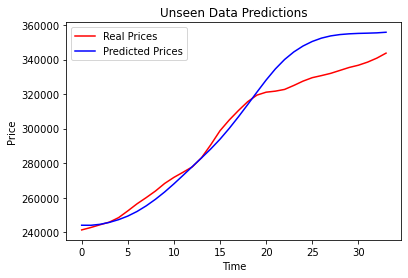

In [22]:
plt.plot(y_val_unscaled, color='red', label='Real Prices')
plt.plot(y_hat_val, color='blue', label='Predicted Prices')
plt.title('Unseen Data Predictions')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show;

Using Our RNN model on all NV Zipcodes

In [23]:
zipcodes = nv_zipcodes
rnn_dict = {} # key is zipcode, value is a list of [validation_mape, test_mape, may_2018 prediction, model name]

for zipcode in range(len(zipcodes)):

    # init a RMM model
    rnn_model = Sequential()

    # we define shape on first layer, (60,1) because we use 60 inputs per prediction
    rnn_model.add(LSTM(units= 60, return_sequences = False, input_shape=((60,1))))
    #rnn_model.add(Dropout(.1))

    # another layer
    #rnn_model.add(LSTM(units= 30, return_sequences = False))
    #rnn_model.add(Dropout(.1))


    # last layer 

    rnn_model.add(Dense(units=1))

    # compile - because this is a regression model we want to minimize MSE

    rnn_model.compile(optimizer='adam', loss='mean_absolute_percentage_error')

    # We get only the specific column(Zipcode from our train and test datas)
    train_data = train.iloc[:,zipcode:zipcode+1].values.astype(int)
    val_data = validation.iloc[:,zipcode:zipcode+1].values.astype(int)
    test_data = test.iloc[:,zipcode:zipcode+1].values.astype(int)
    
    # We are using normalizaion rather than standascaler. 
    # In a upward trending timeseries it is better to not start from negative

    scaler = MinMaxScaler(feature_range=(0,1))
    train_data_scaled = scaler.fit_transform(train_data)
    #test_data_scaled = scaler.transform(test_data)

    # Because we are using 60 previous values to model and predict the next value, 
    # We set X_train from arrays of 60 for each y_train value
    # Same idea for test data sets
    
    X_train = []
    y_train = []
    for i in range(60,len(train_data_scaled)):
        X_train.append(train_data_scaled[i-60:i])
        y_train.append(train_data_scaled[i])
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    # Validation Data 
    data_total_val = pd.concat((train.iloc[:,zipcode:zipcode+1], validation.iloc[:,zipcode:zipcode+1]),axis=0)
    val_input = data_total_val[len(train)-60:].values
    val_input = scaler.transform(val_input)

    X_val = []
    y_val = []
    for i in range(60,len(val_input)):
        X_val.append(val_input[i-60:i])
        y_val.append(val_input[i])
    X_val = np.array(X_val)
    y_val = np.array(y_val)


    # Test Data 
    data_total = pd.concat((train_pre.iloc[:,x:x+1], test.iloc[:,x:x+1]),axis=0)
    test_input = data_total[len(train_pre)-60:].values
    test_input = scaler.transform(test_input)

    X_test = []
    y_test = []
    for i in range(60,len(test_input)):
        X_test.append(test_input[i-60:i])
        y_test.append(test_input[i])
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    filepath = f'rnn_models/rnn_{nv_zipcodes[zipcode]}.hdf5'
    checkpoint = ModelCheckpoint(filepath=filepath,
                                monitor='val_loss',
                                verbose=1,
                                save_best_only=True,
                                mode='min')
    callbacks = [checkpoint]
    # We fit our data to our zipcode specific data
    rnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=callbacks)

    load_file = f'rnn_models/rnn_{nv_zipcodes[zipcode]}.hdf5'
    rnn_best_model = load_model(load_file)
    
    # Make predictions on the validation data using the best model our callback saved

    y_val_hat_raw = rnn_best_model.predict(X_val)
    y_val_hat = scaler.inverse_transform(y_val_hat_raw)
    y_val = scaler.inverse_transform(y_val)
    
    # Use the score on unseen validation data to calculate the MAPE
    list = []
    list.append(np.mean(np.absolute((y_val_hat-y_val)/y_val)))    

    # Make predictions on the test data using the best model our callback saved

    y_test_hat_raw = rnn_best_model.predict(X_test)
    y_test_hat = scaler.inverse_transform(y_test_hat_raw)
    y_test = scaler.inverse_transform(y_test)
    
    # Use the score on unseen test data to calculate the MAPE
    
    list.append(np.mean(np.absolute((y_test_hat-y_test)/y_test)))  


    # We get the last 60 values from our test data which is basically last 60 values in the data set
    last_60 = df_time_series.iloc[-60:,zipcode:zipcode+1].values.astype(int)    
    
    # Before we use our data we scale it
    last_60 = scaler.transform(last_60)
    
    # Our input should be in (x,60,1) format
    x_new_pred = last_60[-60:].reshape(1,60,1)

    # make a prediction, add to the last_60 for the next prediction and 
    y_pred = rnn_best_model.predict(x_new_pred)

    # We add our predition to our list of predictions for zipcode specific predictions list
    list.append(scaler.inverse_transform(y_pred))

    list.append('RNN Model')

    rnn_dict[nv_zipcodes[zipcode]] = list
    
    print(f'Iteration number {zipcode} finished')
    

Epoch 1/50
4/4 [==============================] - ETA: 0s - loss: 97.6323 
Epoch 00001: val_loss improved from inf to 1719807.12500, saving model to rnn_models/rnn_89108.hdf5
4/4 [==============================] - 0s 110ms/step - loss: 97.6323 - val_loss: 1719807.1250
Epoch 2/50
4/4 [==============================] - ETA: 0s - loss: 62.7563
Epoch 00002: val_loss did not improve from 1719807.12500
4/4 [==============================] - 0s 20ms/step - loss: 62.7563 - val_loss: 3582705.2500
Epoch 3/50
4/4 [==============================] - ETA: 0s - loss: 36.4076
Epoch 00003: val_loss did not improve from 1719807.12500
4/4 [==============================] - 0s 21ms/step - loss: 36.4076 - val_loss: 5795991.0000
Epoch 4/50
4/4 [==============================] - ETA: 0s - loss: 28.7729
Epoch 00004: val_loss did not improve from 1719807.12500
4/4 [==============================] - 0s 20ms/step - loss: 28.7729 - val_loss: 6548297.5000
Epoch 5/50
4/4 [==============================] - ETA: 0s -

In [24]:
rnn_dict

{89108: [0.03918008339347867,
  0.02324273698072249,
  array([[206739.39]], dtype=float32),
  'RNN Model'],
 89121: [0.04249053080533641,
  0.09075772556037923,
  array([[204989.14]], dtype=float32),
  'RNN Model'],
 89117: [0.029745497713399783,
  0.034470547823716,
  array([[335406.75]], dtype=float32),
  'RNN Model'],
 89052: [0.09271575816653368,
  0.12895062585632752,
  array([[348933.97]], dtype=float32),
  'RNN Model'],
 89123: [0.025213764982227663,
  0.029378933855414725,
  array([[300457.2]], dtype=float32),
  'RNN Model'],
 89031: [0.02240274911956474,
  0.022868370211432492,
  array([[240816.86]], dtype=float32),
  'RNN Model'],
 89110: [0.03712706337289838,
  0.039684655703900194,
  array([[194479.22]], dtype=float32),
  'RNN Model'],
 89074: [0.02701220876632889,
  0.02964637792464425,
  array([[309999.12]], dtype=float32),
  'RNN Model'],
 89103: [0.020230009987194573,
  0.03665875360957248,
  array([[250961.8]], dtype=float32),
  'RNN Model'],
 89148: [0.034230203529890

In [25]:
pickle_out = open('dictionaries/rnn_dict.pickle','wb')
pickle.dump(rnn_dict, pickle_out)
pickle_out.close()

In [26]:
zipcodes = nv_zipcodes
rnn_2_layer_dict = {} # key is zipcode, value is a list of [validation_mape, test_mape, may_2018 prediction, model name]

for zipcode in range(len(zipcodes)):

    # init a RMM model
    rnn_model = Sequential()

    # we define shape on first layer, (60,1) because we use 60 inputs per prediction
    rnn_model.add(LSTM(units= 60, return_sequences = True, input_shape=((60,1))))
    #rnn_model.add(Dropout(.1))

    # another layer
    rnn_model.add(LSTM(units= 30, return_sequences = False))
    #rnn_model.add(Dropout(.1))


    # last layer 

    rnn_model.add(Dense(units=1))

    # compile - because this is a regression model we want to minimize MSE

    rnn_model.compile(optimizer='adam', loss='mean_absolute_percentage_error')

    # We get only the specific column(Zipcode from our train and test datas)
    train_data = train.iloc[:,zipcode:zipcode+1].values.astype(int)
    val_data = validation.iloc[:,zipcode:zipcode+1].values.astype(int)
    test_data = test.iloc[:,zipcode:zipcode+1].values.astype(int)
    
    # We are using normalizaion rather than standascaler. 
    # In a upward trending timeseries it is better to not start from negative

    scaler = MinMaxScaler(feature_range=(0,1))
    train_data_scaled = scaler.fit_transform(train_data)
    #test_data_scaled = scaler.transform(test_data)

    # Because we are using 60 previous values to model and predict the next value, 
    # We set X_train from arrays of 60 for each y_train value
    # Same idea for test data sets
    
    X_train = []
    y_train = []
    for i in range(60,len(train_data_scaled)):
        X_train.append(train_data_scaled[i-60:i])
        y_train.append(train_data_scaled[i])
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    # Validation Data 
    data_total_val = pd.concat((train.iloc[:,zipcode:zipcode+1], validation.iloc[:,zipcode:zipcode+1]),axis=0)
    val_input = data_total_val[len(train)-60:].values
    val_input = scaler.transform(val_input)

    X_val = []
    y_val = []
    for i in range(60,len(val_input)):
        X_val.append(val_input[i-60:i])
        y_val.append(val_input[i])
    X_val = np.array(X_val)
    y_val = np.array(y_val)


    # Test Data 
    data_total = pd.concat((train_pre.iloc[:,x:x+1], test.iloc[:,x:x+1]),axis=0)
    test_input = data_total[len(train_pre)-60:].values
    test_input = scaler.transform(test_input)

    X_test = []
    y_test = []
    for i in range(60,len(test_input)):
        X_test.append(test_input[i-60:i])
        y_test.append(test_input[i])
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    filepath = f'rnn_models/rnn_2_layer_{nv_zipcodes[zipcode]}.hdf5'
    checkpoint = ModelCheckpoint(filepath=filepath,
                                monitor='val_loss',
                                verbose=1,
                                save_best_only=True,
                                mode='min')
    callbacks = [checkpoint]
    # We fit our data to our zipcode specific data
    rnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=callbacks)

    load_file = f'rnn_models/rnn_2_layer_{nv_zipcodes[zipcode]}.hdf5'
    rnn_best_model = load_model(load_file)
    
    # Make predictions on the validation data using the best model our callback saved

    y_val_hat_raw = rnn_best_model.predict(X_val)
    y_val_hat = scaler.inverse_transform(y_val_hat_raw)
    y_val = scaler.inverse_transform(y_val)
    
    # Use the score on unseen validation data to calculate the MAPE
    list = []
    list.append(np.mean(np.absolute((y_val_hat-y_val)/y_val)))    

    # Make predictions on the test data using the best model our callback saved

    y_test_hat_raw = rnn_best_model.predict(X_test)
    y_test_hat = scaler.inverse_transform(y_test_hat_raw)
    y_test = scaler.inverse_transform(y_test)
    
    # Use the score on unseen test data to calculate the MAPE
    
    list.append(np.mean(np.absolute((y_test_hat-y_test)/y_test)))  


    # We get the last 60 values from our test data which is basically last 60 values in the data set
    last_60 = df_time_series.iloc[-60:,zipcode:zipcode+1].values.astype(int)    
    
    # Before we use our data we scale it
    last_60 = scaler.transform(last_60)
    
    # Our input should be in (x,60,1) format
    x_new_pred = last_60[-60:].reshape(1,60,1)

    # make a prediction, add to the last_60 for the next prediction and 
    y_pred = rnn_best_model.predict(x_new_pred)

    # We add our predition to our list of predictions for zipcode specific predictions list
    list.append(scaler.inverse_transform(y_pred))

    list.append('RNN 2 Layer Model')

    rnn_2_layer_dict[nv_zipcodes[zipcode]] = list
    
    print(f'Iteration number {zipcode} finished')
    

Epoch 1/50
3/4 [=====================>........] - ETA: 0s - loss: 95.1101 
Epoch 00001: val_loss improved from inf to 2720342.50000, saving model to rnn_models/rnn_2_layer_89108.hdf5
4/4 [==============================] - 1s 172ms/step - loss: 92.5584 - val_loss: 2720342.5000
Epoch 2/50
3/4 [=====================>........] - ETA: 0s - loss: 53.4089
Epoch 00002: val_loss did not improve from 2720342.50000
4/4 [==============================] - 0s 33ms/step - loss: 50.4087 - val_loss: 6979132.0000
Epoch 3/50
3/4 [=====================>........] - ETA: 0s - loss: 42.1500
Epoch 00003: val_loss did not improve from 2720342.50000
4/4 [==============================] - 0s 30ms/step - loss: 44.8524 - val_loss: 7411126.5000
Epoch 4/50
3/4 [=====================>........] - ETA: 0s - loss: 33.6772
Epoch 00004: val_loss did not improve from 2720342.50000
4/4 [==============================] - 0s 30ms/step - loss: 33.3076 - val_loss: 5260295.5000
Epoch 5/50
3/4 [=====================>........] - E

In [27]:
rnn_2_layer_dict

{89108: [0.05183628299077933,
  0.07272264615227322,
  array([[203932.25]], dtype=float32),
  'RNN 2 Layer Model'],
 89121: [0.05934586353799749,
  0.11905218217212096,
  array([[204028.97]], dtype=float32),
  'RNN 2 Layer Model'],
 89117: [0.045423029578833055,
  0.0486573295779815,
  array([[333625.56]], dtype=float32),
  'RNN 2 Layer Model'],
 89052: [0.07601308255687164,
  0.1017342541544884,
  array([[359592.]], dtype=float32),
  'RNN 2 Layer Model'],
 89123: [0.0390639462322806,
  0.049680245237950504,
  array([[298008.34]], dtype=float32),
  'RNN 2 Layer Model'],
 89031: [0.03761914968829012,
  0.086026384713096,
  array([[239947.92]], dtype=float32),
  'RNN 2 Layer Model'],
 89110: [0.044870825972410565,
  0.11694839556674393,
  array([[190961.03]], dtype=float32),
  'RNN 2 Layer Model'],
 89074: [0.035538258041011794,
  0.028221731332543347,
  array([[311646.84]], dtype=float32),
  'RNN 2 Layer Model'],
 89103: [0.04046887409556769,
  0.07011383304644439,
  array([[250288.6]],

In [28]:
pickle_out = open('dictionaries/rnn_2_layer_dict.pickle','wb')
pickle.dump(rnn_2_layer_dict, pickle_out)
pickle_out.close()

In [29]:
zipcodes = nv_zipcodes
rnn_w_dropout_dict = {} # key is zipcode, value is a list of [validation_mape, test_mape, may_2018 prediction, model name]

for zipcode in range(len(zipcodes)):

    # init a RMM model
    rnn_model = Sequential()

    # we define shape on first layer, (60,1) because we use 60 inputs per prediction
    rnn_model.add(LSTM(units= 60, return_sequences = False, input_shape=((60,1))))
    rnn_model.add(Dropout(.1))

    # another layer
    #rnn_model.add(LSTM(units= 30, return_sequences = False))
    #rnn_model.add(Dropout(.1))


    # last layer 

    rnn_model.add(Dense(units=1))

    # compile - because this is a regression model we want to minimize MSE

    rnn_model.compile(optimizer='adam', loss='mean_absolute_percentage_error')

    # We get only the specific column(Zipcode from our train and test datas)
    train_data = train.iloc[:,zipcode:zipcode+1].values.astype(int)
    val_data = validation.iloc[:,zipcode:zipcode+1].values.astype(int)
    test_data = test.iloc[:,zipcode:zipcode+1].values.astype(int)
    
    # We are using normalizaion rather than standascaler. 
    # In a upward trending timeseries it is better to not start from negative

    scaler = MinMaxScaler(feature_range=(0,1))
    train_data_scaled = scaler.fit_transform(train_data)
    #test_data_scaled = scaler.transform(test_data)

    # Because we are using 60 previous values to model and predict the next value, 
    # We set X_train from arrays of 60 for each y_train value
    # Same idea for test data sets
    
    X_train = []
    y_train = []
    for i in range(60,len(train_data_scaled)):
        X_train.append(train_data_scaled[i-60:i])
        y_train.append(train_data_scaled[i])
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    # Validation Data 
    data_total_val = pd.concat((train.iloc[:,zipcode:zipcode+1], validation.iloc[:,zipcode:zipcode+1]),axis=0)
    val_input = data_total_val[len(train)-60:].values
    val_input = scaler.transform(val_input)

    X_val = []
    y_val = []
    for i in range(60,len(val_input)):
        X_val.append(val_input[i-60:i])
        y_val.append(val_input[i])
    X_val = np.array(X_val)
    y_val = np.array(y_val)


    # Test Data 
    data_total = pd.concat((train_pre.iloc[:,x:x+1], test.iloc[:,x:x+1]),axis=0)
    test_input = data_total[len(train_pre)-60:].values
    test_input = scaler.transform(test_input)

    X_test = []
    y_test = []
    for i in range(60,len(test_input)):
        X_test.append(test_input[i-60:i])
        y_test.append(test_input[i])
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    filepath = f'rnn_models/rnn_w_dropout_{nv_zipcodes[zipcode]}.hdf5'
    checkpoint = ModelCheckpoint(filepath=filepath,
                                monitor='val_loss',
                                verbose=1,
                                save_best_only=True,
                                mode='min')
    callbacks = [checkpoint]
    # We fit our data to our zipcode specific data
    rnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=callbacks)

    load_file = f'rnn_models/rnn_w_dropout_{nv_zipcodes[zipcode]}.hdf5'
    rnn_best_model = load_model(load_file)
    
    # Make predictions on the validation data using the best model our callback saved

    y_val_hat_raw = rnn_best_model.predict(X_val)
    y_val_hat = scaler.inverse_transform(y_val_hat_raw)
    y_val = scaler.inverse_transform(y_val)
    
    # Use the score on unseen validation data to calculate the MAPE
    list = []
    list.append(np.mean(np.absolute((y_val_hat-y_val)/y_val)))    

    # Make predictions on the test data using the best model our callback saved

    y_test_hat_raw = rnn_best_model.predict(X_test)
    y_test_hat = scaler.inverse_transform(y_test_hat_raw)
    y_test = scaler.inverse_transform(y_test)
    
    # Use the score on unseen test data to calculate the MAPE
    
    list.append(np.mean(np.absolute((y_test_hat-y_test)/y_test)))  


    # We get the last 60 values from our test data which is basically last 60 values in the data set
    last_60 = df_time_series.iloc[-60:,zipcode:zipcode+1].values.astype(int)    
    
    # Before we use our data we scale it
    last_60 = scaler.transform(last_60)
    
    # Our input should be in (x,60,1) format
    x_new_pred = last_60[-60:].reshape(1,60,1)

    # make a prediction, add to the last_60 for the next prediction and 
    y_pred = rnn_best_model.predict(x_new_pred)

    # We add our predition to our list of predictions for zipcode specific predictions list
    list.append(scaler.inverse_transform(y_pred))

    list.append('RNN w/ Dropout Model')

    rnn_w_dropout_dict[nv_zipcodes[zipcode]] = list
    
    print(f'Iteration number {zipcode} finished')
    

Epoch 1/50
4/4 [==============================] - ETA: 0s - loss: 97.7868 
Epoch 00001: val_loss improved from inf to 1622857.37500, saving model to rnn_models/rnn_w_dropout_89108.hdf5
4/4 [==============================] - 0s 122ms/step - loss: 97.7868 - val_loss: 1622857.3750
Epoch 2/50
1/4 [======>.......................] - ETA: 0s - loss: 73.6183
Epoch 00002: val_loss did not improve from 1622857.37500
4/4 [==============================] - 0s 14ms/step - loss: 62.9330 - val_loss: 3759595.7500
Epoch 3/50
1/4 [======>.......................] - ETA: 0s - loss: 44.6639
Epoch 00003: val_loss did not improve from 1622857.37500
4/4 [==============================] - 0s 15ms/step - loss: 34.6804 - val_loss: 6814173.0000
Epoch 4/50
1/4 [======>.......................] - ETA: 0s - loss: 38.2154
Epoch 00004: val_loss did not improve from 1622857.37500
4/4 [==============================] - 0s 15ms/step - loss: 40.6756 - val_loss: 5871658.5000
Epoch 5/50
1/4 [======>.......................] -

In [30]:
rnn_w_dropout_dict

{89108: [0.042096096086745846,
  0.011494359372970792,
  array([[209171.7]], dtype=float32),
  'RNN w/ Dropout Model'],
 89121: [0.042779645239113734,
  0.02311260554084382,
  array([[211242.9]], dtype=float32),
  'RNN w/ Dropout Model'],
 89117: [0.028123232541239714,
  0.045895206093298516,
  array([[332322.88]], dtype=float32),
  'RNN w/ Dropout Model'],
 89052: [0.09167987899429182,
  0.13387906199139668,
  array([[346429.88]], dtype=float32),
  'RNN w/ Dropout Model'],
 89123: [0.02305602132279191,
  0.011121031869867733,
  array([[305719.94]], dtype=float32),
  'RNN w/ Dropout Model'],
 89031: [0.025162764404077675,
  0.027196055950208537,
  array([[242104.56]], dtype=float32),
  'RNN w/ Dropout Model'],
 89110: [0.03143365884024171,
  0.07795946815163626,
  array([[192151.]], dtype=float32),
  'RNN w/ Dropout Model'],
 89074: [0.02461964466857517,
  0.016955612960913333,
  array([[312295.03]], dtype=float32),
  'RNN w/ Dropout Model'],
 89103: [0.031441180452767566,
  0.03146729

In [31]:
pickle_out = open('dictionaries/rnn_w_dropout_dict.pickle','wb')
pickle.dump(rnn_w_dropout_dict, pickle_out)
pickle_out.close()

In [32]:
zipcodes = nv_zipcodes
rnn_2_layer_w_dropout_dict = {} # key is zipcode, value is a list of [validation_mape, test_mape, may_2018 prediction, model name]

for zipcode in range(len(zipcodes)):

    # init a RMM model
    rnn_model = Sequential()

    # we define shape on first layer, (60,1) because we use 60 inputs per prediction
    rnn_model.add(LSTM(units= 60, return_sequences = True, input_shape=((60,1))))
    rnn_model.add(Dropout(.1))

    # another layer
    rnn_model.add(LSTM(units= 30, return_sequences = False))
    rnn_model.add(Dropout(.1))


    # last layer 

    rnn_model.add(Dense(units=1))

    # compile - because this is a regression model we want to minimize MSE

    rnn_model.compile(optimizer='adam', loss='mean_absolute_percentage_error')

    # We get only the specific column(Zipcode from our train and test datas)
    train_data = train.iloc[:,zipcode:zipcode+1].values.astype(int)
    val_data = validation.iloc[:,zipcode:zipcode+1].values.astype(int)
    test_data = test.iloc[:,zipcode:zipcode+1].values.astype(int)
    
    # We are using normalizaion rather than standascaler. 
    # In a upward trending timeseries it is better to not start from negative

    scaler = MinMaxScaler(feature_range=(0,1))
    train_data_scaled = scaler.fit_transform(train_data)
    #test_data_scaled = scaler.transform(test_data)

    # Because we are using 60 previous values to model and predict the next value, 
    # We set X_train from arrays of 60 for each y_train value
    # Same idea for test data sets
    
    X_train = []
    y_train = []
    for i in range(60,len(train_data_scaled)):
        X_train.append(train_data_scaled[i-60:i])
        y_train.append(train_data_scaled[i])
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    # Validation Data 
    data_total_val = pd.concat((train.iloc[:,zipcode:zipcode+1], validation.iloc[:,zipcode:zipcode+1]),axis=0)
    val_input = data_total_val[len(train)-60:].values
    val_input = scaler.transform(val_input)

    X_val = []
    y_val = []
    for i in range(60,len(val_input)):
        X_val.append(val_input[i-60:i])
        y_val.append(val_input[i])
    X_val = np.array(X_val)
    y_val = np.array(y_val)


    # Test Data 
    data_total = pd.concat((train_pre.iloc[:,x:x+1], test.iloc[:,x:x+1]),axis=0)
    test_input = data_total[len(train_pre)-60:].values
    test_input = scaler.transform(test_input)

    X_test = []
    y_test = []
    for i in range(60,len(test_input)):
        X_test.append(test_input[i-60:i])
        y_test.append(test_input[i])
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    filepath = f'rnn_models/rnn_2_layer_w_dropout_{nv_zipcodes[zipcode]}.hdf5'
    checkpoint = ModelCheckpoint(filepath=filepath,
                                monitor='val_loss',
                                verbose=1,
                                save_best_only=True,
                                mode='min')
    callbacks = [checkpoint]
    # We fit our data to our zipcode specific data
    rnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=callbacks)

    load_file = f'rnn_models/rnn_2_layer_w_dropout_{nv_zipcodes[zipcode]}.hdf5'
    rnn_best_model = load_model(load_file)
    
    # Make predictions on the validation data using the best model our callback saved

    y_val_hat_raw = rnn_best_model.predict(X_val)
    y_val_hat = scaler.inverse_transform(y_val_hat_raw)
    y_val = scaler.inverse_transform(y_val)
    
    # Use the score on unseen validation data to calculate the MAPE
    list = []
    list.append(np.mean(np.absolute((y_val_hat-y_val)/y_val)))    

    # Make predictions on the test data using the best model our callback saved

    y_test_hat_raw = rnn_best_model.predict(X_test)
    y_test_hat = scaler.inverse_transform(y_test_hat_raw)
    y_test = scaler.inverse_transform(y_test)
    
    # Use the score on unseen test data to calculate the MAPE
    
    list.append(np.mean(np.absolute((y_test_hat-y_test)/y_test)))  


    # We get the last 60 values from our test data which is basically last 60 values in the data set
    last_60 = df_time_series.iloc[-60:,zipcode:zipcode+1].values.astype(int)    
    
    # Before we use our data we scale it
    last_60 = scaler.transform(last_60)
    
    # Our input should be in (x,60,1) format
    x_new_pred = last_60[-60:].reshape(1,60,1)

    # make a prediction, add to the last_60 for the next prediction and 
    y_pred = rnn_best_model.predict(x_new_pred)

    # We add our predition to our list of predictions for zipcode specific predictions list
    list.append(scaler.inverse_transform(y_pred))

    list.append('RNN 2 Layer w/ Dropout Model')

    rnn_2_layer_w_dropout_dict[nv_zipcodes[zipcode]] = list
    
    print(f'Iteration number {zipcode} finished')
    

Epoch 1/50
3/4 [=====================>........] - ETA: 0s - loss: 70.0537
Epoch 00001: val_loss improved from inf to 3211392.50000, saving model to rnn_models/rnn_2_layer_w_dropout_89108.hdf5
4/4 [==============================] - 1s 179ms/step - loss: 69.0224 - val_loss: 3211392.5000
Epoch 2/50
3/4 [=====================>........] - ETA: 0s - loss: 37.7663
Epoch 00002: val_loss did not improve from 3211392.50000
4/4 [==============================] - 0s 30ms/step - loss: 38.9468 - val_loss: 6053897.5000
Epoch 3/50
3/4 [=====================>........] - ETA: 0s - loss: 32.6979
Epoch 00003: val_loss did not improve from 3211392.50000
4/4 [==============================] - 0s 28ms/step - loss: 33.5277 - val_loss: 4841735.5000
Epoch 4/50
3/4 [=====================>........] - ETA: 0s - loss: 27.2749
Epoch 00004: val_loss did not improve from 3211392.50000
4/4 [==============================] - 0s 28ms/step - loss: 27.4926 - val_loss: 3558714.2500
Epoch 5/50
3/4 [=====================>....

In [33]:
rnn_2_layer_w_dropout_dict

{89108: [0.05576037587385258,
  0.10022688188956996,
  array([[201378.23]], dtype=float32),
  'RNN 2 Layer w/ Dropout Model'],
 89121: [0.06849651453079002,
  0.05924698661308473,
  array([[208812.78]], dtype=float32),
  'RNN 2 Layer w/ Dropout Model'],
 89117: [0.05424300983742158,
  0.0446011932966616,
  array([[335053.25]], dtype=float32),
  'RNN 2 Layer w/ Dropout Model'],
 89052: [0.13342067113841746,
  0.19277669270929434,
  array([[317974.22]], dtype=float32),
  'RNN 2 Layer w/ Dropout Model'],
 89123: [0.038336458916399176,
  0.05668366720734854,
  array([[295341.53]], dtype=float32),
  'RNN 2 Layer w/ Dropout Model'],
 89031: [0.02892018506534615,
  0.0663032133295658,
  array([[238809.42]], dtype=float32),
  'RNN 2 Layer w/ Dropout Model'],
 89110: [0.03562953377473541,
  0.0785409429780751,
  array([[194393.67]], dtype=float32),
  'RNN 2 Layer w/ Dropout Model'],
 89074: [0.04477026940243566,
  0.07840512416223402,
  array([[300290.06]], dtype=float32),
  'RNN 2 Layer w/ Dro

In [34]:
pickle_out = open('dictionaries/rnn_2_layer_w_dropout_dict.pickle','wb')
pickle.dump(rnn_2_layer_w_dropout_dict, pickle_out)
pickle_out.close()

# Facebook Prophet Model

In [12]:
size_fbp = int(len(df_time_series)*.75)
train_fbp_df = df_time_series.iloc[:size_fbp]
test_fbp_df = df_time_series.iloc[size_fbp:]

In [13]:
zipcode_fbp_try = 89139

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


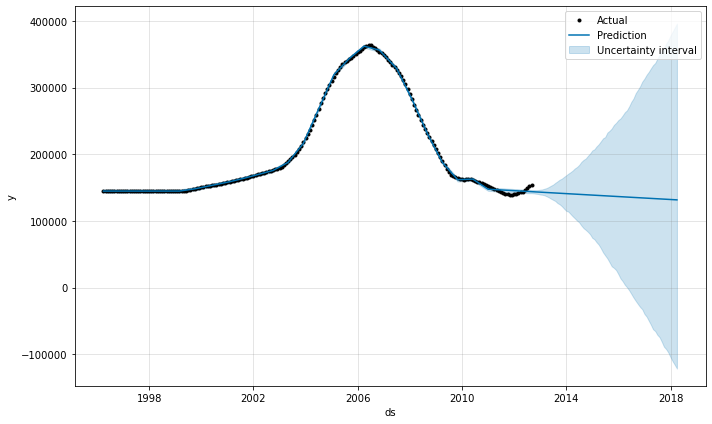

In [14]:
train_fbp = pd.DataFrame({'ds':train_fbp_df.index, 'y':train_fbp_df[zipcode_fbp_try]})
# Create a Prophet instance and fit the model
m = Prophet(yearly_seasonality=False, changepoint_range=0.9, changepoint_prior_scale=0.5)
m.fit(train_fbp)
# Create a dataframe holding dates for our forecast of one month period
future = m.make_future_dataframe(periods=67, freq='M')
# Create a forecast object which will hold all of the resulting data from the future.
forecast = m.predict(future)
fig = m.plot(forecast)
plt.legend(['Actual', 'Prediction', 'Uncertainty interval'])
plt.show()

In [15]:
forecast.head()

ds          trend     yhat_lower     yhat_upper    trend_lower  \
0 1996-04-01  144732.277715  142154.193596  147365.597388  144732.277715   
1 1996-05-01  144732.659517  142226.026197  147278.614855  144732.659517   
2 1996-06-01  144733.054044  142196.685947  147247.298229  144733.054044   
3 1996-07-01  144733.435845  142242.343656  147362.348752  144733.435845   
4 1996-08-01  144733.830373  142179.074715  147277.349630  144733.830373   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  144732.277715             0.0                   0.0                   0.0   
1  144732.659517             0.0                   0.0                   0.0   
2  144733.054044             0.0                   0.0                   0.0   
3  144733.435845             0.0                   0.0                   0.0   
4  144733.830373             0.0                   0.0                   0.0   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   

   multiplicative_terms_upper           yhat  
0                         0.0  144732.277715  
1                         0.0  144732.659517  
2                         0.0  144733.054044  
3                         0.0  144733.435845  
4                         0.0  144733.830373

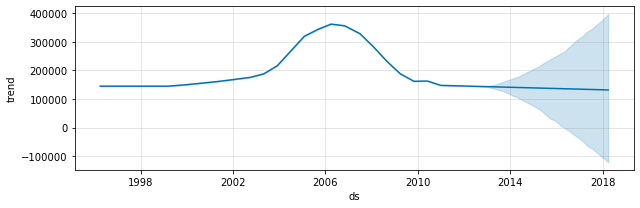

In [16]:
fig = m.plot_components(forecast)


In [17]:
# validation period
horizon = '365 days'

# starting point for validating
initial = str(365 * 5) + ' days'  

# spacing between cutoff dates
period = '365 days' 

df_cv = cross_validation(m, initial=initial, period=period, horizon=horizon, parallel='processes')

df_metrics = performance_metrics(df_cv) 

# mape values for cross validations, we will use this to 
np.average(df_metrics.mape)

INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fca6fa31070>


0.08032253435421008

In [18]:
# Our last 67 predictions are our preditions for our test data, we will use MAPE to determine our models power nd compare it to other models.
predictions = forecast.iloc[-len(test_fbp_df):]['yhat']
actuals = df_time_series[89139]

In [26]:
actuals

1996-04-01    145100.0
1996-05-01    144900.0
1996-06-01    144700.0
1996-07-01    144500.0
1996-08-01    144400.0
                ...   
2017-12-01    273100.0
2018-01-01    276700.0
2018-02-01    280100.0
2018-03-01    283100.0
2018-04-01    284900.0
Name: 89139, Length: 265, dtype: float64

In [21]:
actuals.index

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

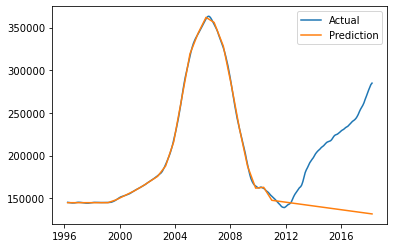

In [23]:
#fig = m.plot(forecast)
#forecast
fig, ax = plt.subplots()
ax.plot(forecast.ds, actuals)
ax.plot(forecast.ds, forecast.yhat)
#ax = m.plot(forecast)

plt.legend(['Actual', 'Prediction', 'Uncertainty interval'])
plt.show()

In [28]:
mape_fbp_model = np.mean(np.absolute((predictions.values-actuals.values[-67:])/actuals.values[-67:]))
mape_fbp_model

0.35914584173251585

## Facebook Prophet Model For Loop for All Zip-Codes

Because we were predicting 6 years into the future we were getting bad results. We will now train the whole data when testing fot test data and predicting 2018 May

In [178]:
zipcodes = nv_zipcodes
fbp_50_scale_dict = {} # key is zipcode, value is a list of [validation_mape, test_mape, may_2018 prediction, model name]
i=0
for zipcode in zipcodes:
    # create a new dataframe with dates and prices
    train_fbp = pd.DataFrame({'ds':train_fbp_df.index, 'y':train_fbp_df[zipcode]})
    # create a Prophet instance and fit the model
    m = Prophet(yearly_seasonality=False, changepoint_range=0.9, changepoint_prior_scale=0.5)
    m.fit(train_fbp)

    # create a dataframe holding dates for our forecast of 67 month period(Our test data size)
    future = m.make_future_dataframe(periods=68, freq='M')
    # create a forecast object which will hold all of the resulting data from the future.
    forecast = m.predict(future)

    # use cross validation starting from 5 years time with 1 year periods and 1 year between periods
    # validation period
    horizon = '365 days'

    # starting point for validating
    initial = str(365 * 5) + ' days'  

    # spacing between cutoff dates
    period = '365 days' 

    df_cv = cross_validation(m, initial=initial, period=period, horizon=horizon, parallel='processes')

    df_metrics = performance_metrics(df_cv) 

    # mape values for cross validations, we will use this to 
    list = []
    list.append(np.average(df_metrics.mape))
    
    # our last 67 predictions (except the very last one which is going to be our future prediction, we do not have actual price for that) are our preditions for our test data.
    # we will use MAPE to determine our models power nd compare it to other models.
    test_fbp = pd.DataFrame({'ds':df_time_series.index, 'y':df_time_series[zipcode]}) 
    m2 = Prophet(yearly_seasonality=False, changepoint_range=0.9, changepoint_prior_scale=0.5)
    m2.fit(test_fbp)
    future2 = m2.make_future_dataframe(periods=1, freq='M')
    forecast2 = m.predict(future2)
    
    predictions = forecast2.iloc[-len(test_fbp_df)-1:-1]['yhat']
    actuals = test_fbp_df[zipcode]
    
    # we are using our predictions for our test data to calculate MAPE and using this we will see how our data is doing on unseen data
    list.append(np.mean(np.absolute((predictions.values-actuals.values)/actuals.values)))
    
    # we add the last prediction as our future prediction
    list.append(forecast.iloc[-1]['yhat'])

    # we are mentioning the name of the model in the dictionary so we can later compare models and get the best model for each zip-code
    list.append('Facebook Prophet 0.5 Scale')
    
    # we save our results in a dictionary to later analyze
    fbp_50_scale_dict[zipcode] = list
    
    
    print(f'iteration={i}')
    i += 1

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8bce69730>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=0


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa908ebbb20>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=1


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa94c402370>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=2


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8df120a00>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=3


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8b8dc2fd0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=4


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa9c3b1ea90>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=5


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa9699aed30>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=6


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa99a4b50a0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=7


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa9ca208640>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=8


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa904527340>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=9


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8e2ce97c0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=10


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8ea1faca0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=11


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8df11f2e0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=12


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa962cc3f70>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=13


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8e2ce4c10>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=14


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa98f5be070>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=15


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8d3df4070>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=16


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8ae7b1400>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=17


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa905457d30>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=18


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa905457220>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=19


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa92ba346a0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=20


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8efdeedc0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=21


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8f7622430>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=22


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa90a8bc160>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=23


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa90a8bc550>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=24


ValueError: Dataframe has less than 2 non-NaN rows.

In [92]:
zipcodes = nv_zipcodes
fbp_25_scale_dict = {} # key is zipcode, value is a list of [validation_mape, test_mape, may_2018 prediction, model name]
i=0
for zipcode in zipcodes:
    # create a new dataframe with dates and prices
    train_fbp = pd.DataFrame({'ds':train_fbp_df.index, 'y':train_fbp_df[zipcode]})
    # create a Prophet instance and fit the model
    m = Prophet(yearly_seasonality=False, changepoint_range=0.9, changepoint_prior_scale=0.25)
    m.fit(train_fbp)

    # create a dataframe holding dates for our forecast of 67 month period(Our test data size)
    future = m.make_future_dataframe(periods=68, freq='M')
    # create a forecast object which will hold all of the resulting data from the future.
    forecast = m.predict(future)

    # use cross validation starting from 5 years time with 1 year periods and 1 year between periods
    # validation period
    horizon = '365 days'

    # starting point for validating
    initial = str(365 * 5) + ' days'  

    # spacing between cutoff dates
    period = '365 days' 

    df_cv = cross_validation(m, initial=initial, period=period, horizon=horizon, parallel='processes')

    df_metrics = performance_metrics(df_cv) 

    # mape values for cross validations, we will use this to 
    list = []
    list.append(np.average(df_metrics.mape))
    
    # our last 67 predictions (except the very last one which is going to be our future prediction, we do not have actual price for that) are our preditions for our test data.
    # we will use MAPE to determine our models power nd compare it to other models.
    test_fbp = pd.DataFrame({'ds':df_time_series.index, 'y':df_time_series[zipcode]}) 
    m2 = Prophet(yearly_seasonality=False, changepoint_range=0.9, changepoint_prior_scale=0.5)
    m2.fit(test_fbp)
    future2 = m2.make_future_dataframe(periods=1, freq='M')
    forecast2 = m.predict(future2)
    
    predictions = forecast2.iloc[-len(test_fbp_df)-1:-1]['yhat']
    actuals = test_fbp_df[zipcode]
    
    # we are using our predictions for our test data to calculate MAPE and using this we will see how our data is doing on unseen data
    list.append(np.mean(np.absolute((predictions.values-actuals.values)/actuals.values)))
    
    # we add the last prediction as our future prediction
    list.append(forecast.iloc[-1]['yhat'])

    # we are mentioning the name of the model in the dictionary so we can later compare models and get the best model for each zip-code
    list.append('Facebook Prophet 0.5 Scale')
    
    # we save our results in a dictionary to later analyze
    fbp_25_scale_dict[zipcode] = list
    
    
    print(f'iteration={i}')
    i += 1

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa908ee04c0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=0


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8b8d93490>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=1


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa908ebb2b0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=2


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8b8d93490>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=3


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa908ee06d0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=4


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8a3c371f0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=5


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8d3df4a30>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=6


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8afc0f820>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=7


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8b8d935e0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=8


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa944f3a9d0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=9


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8df1087c0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=10


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa931816460>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=11


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa929baa2e0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=12


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8b8dc24f0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=13


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8b8dc2370>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=14


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8e4882a90>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=15


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8e4882e50>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=16


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa905457400>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=17


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa963c5c730>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=18


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa905457d30>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=19


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa905457160>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=20


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa936188ca0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=21


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8df11d7f0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=22


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8df11d5e0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=23


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8b8dae3a0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=24


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa905457e50>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=25


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8df11da00>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=26


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa900886e50>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=27


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa98f5bef70>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=28


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8b8daeac0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=29


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa98f5bea30>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=30


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa94c40fb50>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=31


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8df12dd60>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=32


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8eb880d60>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=33


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8eb880430>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=34


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa94c402490>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=35


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8ae7b1c10>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=36


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8eb880fd0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=37


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8e29191c0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=38


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8ea1ce220>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=39


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8ea1ce2b0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=40


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8acb72220>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=41


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8f4eaaee0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=42


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8de035bb0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=43


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa992f5eb80>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=44


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8b8d93490>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=45


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8a6440370>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=46


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa924140550>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=47


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8ea1fafa0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=48


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8e1324d60>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=49


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa931835a30>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=50


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa936188ca0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=51


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa9b6c74e50>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=52


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8de00a8b0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=53


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7faa44eb54f0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=54


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8de00a160>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=55


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8acb721f0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=56


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa90c0e59a0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=57


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8e1324d60>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=58


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8b8dc23a0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=59


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa931816250>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=60


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8acb72220>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=61


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa944f3ad60>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=62


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8acb721f0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=63


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa936188ca0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=64


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8acbb2e80>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=65


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8f4eaaee0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=66


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa948d22ca0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=67


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8df11d340>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=68


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa98f5a5f40>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=69


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8e1324d60>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=70


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8df102700>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=71


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8df11d760>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=72


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa9008be9a0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=73


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa946ddb460>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=74


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa948d22ca0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=75


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8e4882d30>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=76


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8e48825b0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=77


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8ffa1fc70>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=78


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8afc03250>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=79


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8ffa1ff70>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=80


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa950feeaf0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=81


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8df10a310>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=82


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8df10ae20>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=83


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa936188ca0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=84


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa908eb2f70>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=85


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa908eb2a00>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=86


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8afc0f6a0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=87


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8df1202e0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=88


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa950feeaf0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=89


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8efd308e0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=90


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8ad368d00>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=91


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8de081b20>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=92


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa90c0e59d0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=93


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa98f5a53a0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=94


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa90c0e59d0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=95


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa963c35dc0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=96


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7faa44eb54f0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=97


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7faa44eb54f0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=98


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa8f4eaaee0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=99


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa948d22ca0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=100


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa98f5a58b0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


iteration=101


INFO:fbprophet:Making 11 forecasts with cutoffs between 2001-09-04 00:00:00 and 2011-09-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7faa44eb54f0>


iteration=102


In [162]:
test_fbp

89108     89121     89117     89052     89123     89031  \
2012-10-01   82900.0   86400.0  190500.0  260100.0  157900.0  112500.0   
2012-11-01   84900.0   88200.0  193000.0  263900.0  159800.0  114600.0   
2012-12-01   87700.0   90400.0  196200.0  268300.0  162500.0  117200.0   
2013-01-01   90400.0   92600.0  199000.0  271800.0  164900.0  119400.0   
2013-02-01   92900.0   94600.0  201400.0  274800.0  166900.0  121500.0   
...              ...       ...       ...       ...       ...       ...   
2017-12-01  197300.0  198700.0  327100.0  403800.0  290400.0  231600.0   
2018-01-01  200700.0  201500.0  330700.0  407300.0  294300.0  234600.0   
2018-02-01  203500.0  204000.0  334600.0  410400.0  297400.0  237200.0   
2018-03-01  206600.0  206700.0  338800.0  413700.0  300200.0  239800.0   
2018-04-01  209300.0  208600.0  342000.0  416100.0  302400.0  241900.0   

               89110     89074     89103     89148  ...     89444     89085  \
2012-10-01   74300.0  166100.0  118100.0  168800.0  ...  187600.0  191800.0   
2012-11-01   75800.0  168900.0  119300.0  170700.0  ...  192900.0  194100.0   
2012-12-01   78000.0  171600.0  121200.0  173300.0  ...  198500.0  197000.0   
2013-01-01   79700.0  173300.0  123700.0  175700.0  ...  201700.0  199300.0   
2013-02-01   81300.0  175100.0  126300.0  178300.0  ...  203800.0  201300.0   
...              ...       ...       ...       ...  ...       ...       ...   
2017-12-01  186600.0  300100.0  240400.0  291400.0  ...  266200.0  313100.0   
2018-01-01  189200.0  303500.0  243700.0  294100.0  ...  270000.0  316500.0   
2018-02-01  191700.0  306700.0  246300.0  296900.0  ...  275600.0  319500.0   
2018-03-01  194500.0  309800.0  249500.0  299400.0  ...  282100.0  322400.0   
2018-04-01  196600.0  312200.0  252000.0  300800.0  ...  286000.0  324700.0   

               89034     89021     89439     89411     89124     89440  \
2012-10-01  240300.0  170100.0  276200.0  446600.0  203100.0  108200.0   
2012-11-01  242900.0  171500.0  274100.0  454300.0  206300.0  110000.0   
2012-12-01  246300.0  173200.0  271100.0  459000.0  210100.0  111500.0   
2013-01-01  249200.0  174100.0  269100.0  463200.0  212400.0  113500.0   
2013-02-01  251500.0  175300.0  270100.0  470400.0  211400.0  116100.0   
...              ...       ...       ...       ...       ...       ...   
2017-12-01  311700.0  298300.0  444500.0  639300.0  316800.0  199800.0   
2018-01-01  315500.0  299900.0  449500.0  642500.0  317600.0  201600.0   
2018-02-01  319500.0  302500.0  450100.0  653800.0  323400.0  207000.0   
2018-03-01  323600.0  305700.0  451100.0  666000.0  334700.0  216500.0   
2018-04-01  326600.0  307800.0  455300.0  672600.0  344300.0  222800.0   

                89413     89155  
2012-10-01  1245300.0  213300.0  
2012-11-01  1263100.0  215100.0  
2012-12-01  1274400.0  218300.0  
2013-01-01  1282400.0  221400.0  
2013-02-01  1301100.0  224300.0  
...               ...       ...  
2017-12-01  2098400.0  348900.0  
2018-01-01  2121300.0  350400.0  
2018-02-01  2153600.0  353000.0  
2018-03-01  2167100.0  356000.0  
2018-04-01  2161900.0  357200.0  

[67 rows x 103 columns]

In [93]:
pickle_out = open('dictionaries/fbp_25_scale_dict.pickle','wb')
pickle.dump(fbp_25_scale_dict, pickle_out)
pickle_out.close()

pickle_out = open('dictionaries/fbp_50_scale_dict.pickle','wb')
pickle.dump(fbp_50_scale_dict, pickle_out)
pickle_out.close()

In [95]:
models = [rnn_dict, rnn_2_layer_dict, rnn_w_dropout_dict, rnn_2_layer_w_dropout_dict, fbp_25_scale_dict, fbp_50_scale_dict]
best_model_dict = {}
for zipcode in rnn_dict.keys():
    best_model = [1,1]
    for model in models:
        if model[zipcode][0]<best_model[0]:
            best_model = model[zipcode]
    best_model_dict[zipcode] = best_model

In [96]:
best_model_dict


{89108: [0.03918008339347867,
  0.02324273698072249,
  array([[206739.39]], dtype=float32),
  'RNN Model'],
 89121: [0.04249053080533641,
  0.09075772556037923,
  array([[204989.14]], dtype=float32),
  'RNN Model'],
 89117: [0.028123232541239714,
  0.045895206093298516,
  array([[332322.88]], dtype=float32),
  'RNN w/ Dropout Model'],
 89052: [0.07413099525999427,
  0.30862520819303074,
  229682.2443676644,
  'Facebook Prophet 0.5 Scale'],
 89123: [0.02305602132279191,
  0.011121031869867733,
  array([[305719.94]], dtype=float32),
  'RNN w/ Dropout Model'],
 89031: [0.02240274911956474,
  0.022868370211432492,
  array([[240816.86]], dtype=float32),
  'RNN Model'],
 89110: [0.03143365884024171,
  0.07795946815163626,
  array([[192151.]], dtype=float32),
  'RNN w/ Dropout Model'],
 89074: [0.02461964466857517,
  0.016955612960913333,
  array([[312295.03]], dtype=float32),
  'RNN w/ Dropout Model'],
 89103: [0.020230009987194573,
  0.03665875360957248,
  array([[250961.8]], dtype=float32)

In [97]:
model_types = []
for item in best_model_dict.values():
    model_types.append([item[3]])
list = []
for item in model_types:
    list.append(item[0])
labels = set(list)
sizes = []
#list.count(labels[0])
for i in labels:
    sizes.append(list.count(i))
labels, sizes

({'Facebook Prophet 0.5 Scale',
  'RNN 2 Layer Model',
  'RNN 2 Layer w/ Dropout Model',
  'RNN Model',
  'RNN w/ Dropout Model'},
 [6, 14, 47, 35, 1])

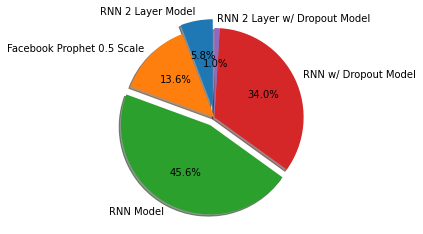

In [101]:
explode = (0.1, 0, 0.1, 0, 0)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.xticks(fontsize= 50)
plt.show()

In [105]:
predictions_05_18 = []
for zipcode in df_time_series.columns:
    predictions_05_18.append(best_model_dict[zipcode][2].astype(int))

In [106]:
predictions_05_18

[array([[206739]]),
 array([[204989]]),
 array([[332322]]),
 229682,
 array([[305719]]),
 array([[240816]]),
 array([[192151]]),
 array([[312295]]),
 array([[250961]]),
 array([[302781]]),
 array([[265378]]),
 array([[236049]]),
 array([[276296]]),
 array([[211914]]),
 array([[173611]]),
 array([[280435]]),
 array([[280800]]),
 array([[331004]]),
 array([[432338]]),
 array([[378837]]),
 array([[251806]]),
 array([[271911]]),
 array([[391011]]),
 array([[208524]]),
 array([[335998]]),
 62100,
 array([[243782]]),
 array([[227407]]),
 array([[270413]]),
 array([[218885]]),
 array([[287437]]),
 array([[301354]]),
 array([[292375]]),
 array([[304314]]),
 array([[402596]]),
 array([[270984]]),
 array([[412659]]),
 array([[197391]]),
 array([[650157]]),
 array([[300737]]),
 array([[270581]]),
 array([[313139]]),
 array([[316642]]),
 array([[252159]]),
 array([[316948]]),
 array([[262186]]),
 array([[205930]]),
 array([[296423]]),
 115600,
 array([[240277]]),
 array([[296102]]),
 array([[26516

Adding our best predictions to the Nevada DataFrame

In [107]:
df_time_series.loc['2018-05-01_pred'] = predictions_05_18


/Users/ferityikar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [108]:
df_time_series

89108       89121       89117     89052       89123  \
1996-04-01 00:00:00      102500      106800      165100  185700.0      144000   
1996-05-01 00:00:00      102500      107000      164500  186300.0      143500   
1996-06-01 00:00:00      102500      107200      164000  186900.0      143100   
1996-07-01 00:00:00      102600      107400      163500  187400.0      142700   
1996-08-01 00:00:00      102700      107600      163200  187700.0      142400   
...                         ...         ...         ...       ...         ...   
2018-01-01 00:00:00      200700      201500      330700  407300.0      294300   
2018-02-01 00:00:00      203500      204000      334600  410400.0      297400   
2018-03-01 00:00:00      206600      206700      338800  413700.0      300200   
2018-04-01 00:00:00      209300      208600      342000  416100.0      302400   
2018-05-01_pred      [[206739]]  [[204989]]  [[332322]]  229682.0  [[305719]]   

                          89031       89110       89074       89103  \
1996-04-01 00:00:00      122800       95800      148000      118900   
1996-05-01 00:00:00      122800       95800      147800      119000   
1996-06-01 00:00:00      122700       95800      147600      119000   
1996-07-01 00:00:00      122700       95900      147300      119100   
1996-08-01 00:00:00      122700       96100      147100      119200   
...                         ...         ...         ...         ...   
2018-01-01 00:00:00      234600      189200      303500      243700   
2018-02-01 00:00:00      237200      191700      306700      246300   
2018-03-01 00:00:00      239800      194500      309800      249500   
2018-04-01 00:00:00      241900      196600      312200      252000   
2018-05-01_pred      [[240816]]  [[192151]]  [[312295]]  [[250961]]   

                          89148  ...       89444       89085       89034  \
1996-04-01 00:00:00      157300  ...      116800      170900      196000   
1996-05-01 00:00:00      156000  ...      117000      170800      196000   
1996-06-01 00:00:00      154700  ...      117200      170700      195900   
1996-07-01 00:00:00      153500  ...      117400      170700      195700   
1996-08-01 00:00:00      152600  ...      117600      170700      195400   
...                         ...  ...         ...         ...         ...   
2018-01-01 00:00:00      294100  ...      270000      316500      315500   
2018-02-01 00:00:00      296900  ...      275600      319500      319500   
2018-03-01 00:00:00      299400  ...      282100      322400      323600   
2018-04-01 00:00:00      300800  ...      286000      324700      326600   
2018-05-01_pred      [[302781]]  ...  [[265535]]  [[324097]]  [[320045]]   

                          89021       89439       89411       89124     89440  \
1996-04-01 00:00:00      153200      184200      299200      166100  293200.0   
1996-05-01 00:00:00      153700      185000      299600      166600  293200.0   
1996-06-01 00:00:00      154100      185800      299900      167300  293200.0   
1996-07-01 00:00:00      154400      186400      300200      167900  293200.0   
1996-08-01 00:00:00      154700      186900      300500      168600  293200.0   
...                         ...         ...         ...         ...       ...   
2018-01-01 00:00:00      299900      449500      642500      317600  201600.0   
2018-02-01 00:00:00      302500      450100      653800      323400  207000.0   
2018-03-01 00:00:00      305700      451100      666000      334700  216500.0   
2018-04-01 00:00:00      307800      455300      672600      344300  222800.0   
2018-05-01_pred      [[308233]]  [[434206]]  [[643628]]  [[320317]]   35091.0   

                           89413       89155  
1996-04-01 00:00:00       562400      176400  
1996-05-01 00:00:00       562800      176300  
1996-06-01 00:00:00       562700      176100  
1996-07-01 00:00:00       562400      176000  
1996-08-01 00:00:00       562300      175900  
...                          ...

In [109]:
investment_return = {}
for i in df_time_series.columns:
    investment_return[i] = (df_time_series[i][-1]-df_time_series[i][-2])/df_time_series[i][-2]

In [110]:
investment_return = dict(sorted(investment_return.items(), key=lambda item: item[1]))
investment_return


{89440: -0.8425,
 89060: -0.714214002642008,
 89048: -0.6369089099054256,
 89030: -0.5895571711830799,
 89061: -0.5848552036199095,
 89109: -0.5553546634470269,
 89512: -0.5021533161068045,
 89429: -0.463519313304721,
 89408: -0.46042868920032975,
 89052: -0.44801249699591444,
 89403: -0.4274891774891775,
 89447: -0.37210682492581604,
 89815: -0.3431203627370157,
 89801: -0.3185954135954136,
 89704: array([[-0.09692452]]),
 89179: array([[-0.09251323]]),
 89444: array([[-0.07155594]]),
 89124: array([[-0.06965728]]),
 89413: array([[-0.06936584]]),
 89451: array([[-0.0665769]]),
 89439: array([[-0.04632989]]),
 89509: array([[-0.04413442]]),
 89411: array([[-0.04307464]]),
 89423: array([[-0.04017958]]),
 89448: array([[-0.03952214]]),
 89441: array([[-0.03936519]]),
 89521: array([[-0.03338295]]),
 89410: array([[-0.03315287]]),
 89144: array([[-0.03263383]]),
 89506: array([[-0.03216535]]),
 89519: array([[-0.03167458]]),
 89706: array([[-0.03011132]]),
 89449: array([[-0.02910737]])

In [111]:
list = []
for i in investment_return.keys():
    list.append(i)
best_5_investments = list[-5:]

In [112]:
best_5_investments

[89139, 89510, 89123, 89503, 89436]

In [113]:
investment_chart_data = df_time_series[best_5_investments][-12:]
investment_chart_data

89139       89510       89123       89503  \
2017-06-01 00:00:00      254200      400200      270400      272100   
2017-07-01 00:00:00      256600      408000      273000      275900   
2017-08-01 00:00:00      258900      412500      275600      280000   
2017-09-01 00:00:00      261900      415700      278900      284300   
2017-10-01 00:00:00      265800      415100      283000      288500   
2017-11-01 00:00:00      269300      416500      286500      292700   
2017-12-01 00:00:00      273100      419500      290400      296000   
2018-01-01 00:00:00      276700      421800      294300      298500   
2018-02-01 00:00:00      280100      420600      297400      301400   
2018-03-01 00:00:00      283100      418300      300200      306400   
2018-04-01 00:00:00      284900      415500      302400      310200   
2018-05-01_pred      [[287437]]  [[419795]]  [[305719]]  [[316642]]   

                          89436  
2017-06-01 00:00:00      337300  
2017-07-01 00:00:00      341100  
2017-08-01 00:00:00      344900  
2017-09-01 00:00:00      349200  
2017-10-01 00:00:00      352700  
2017-11-01 00:00:00      355300  
2017-12-01 00:00:00      357800  
2018-01-01 00:00:00      360100  
2018-02-01 00:00:00      361900  
2018-03-01 00:00:00      365800  
2018-04-01 00:00:00      369700  
2018-05-01_pred      [[378837]]

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

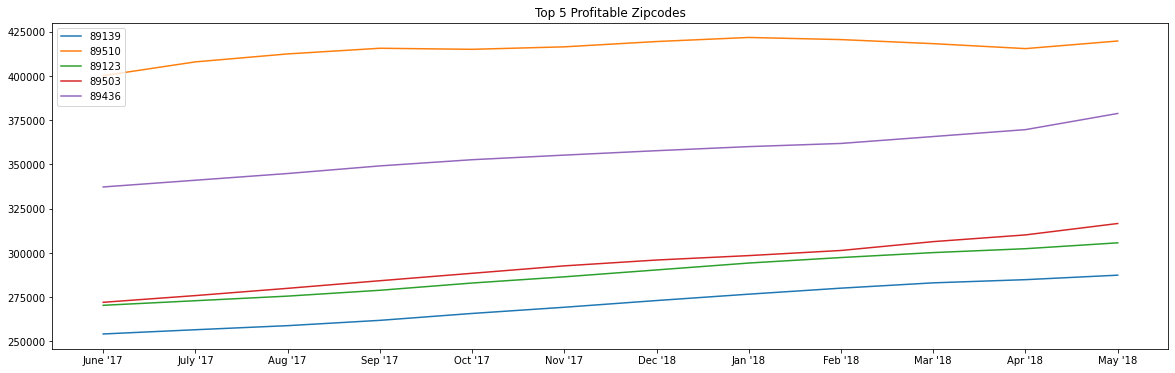

<Figure size 432x288 with 0 Axes>

In [114]:
months = ["June '17", "July '17","Aug '17","Sep '17","Oct '17","Nov '17","Dec '18","Jan '18","Feb '18","Mar '18","Apr '18", "May '18"]
fig, ax = plt.subplots(figsize=(20,6))
fig = plt.figure()

ax.plot(months, investment_chart_data[89139])
ax.plot(months, investment_chart_data[89510])
ax.plot(months, investment_chart_data[89123])
ax.plot(months, investment_chart_data[89503])
ax.plot(months, investment_chart_data[89436])

ax.set_title('Top 5 Profitable Zipcodes')
ax.legend(['89139','89510','89123','89503','89436'], loc=('upper left'));
